## Importing necessary libraries

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

## Our actor-critic class definitions by inheriting nn.Module from pytorch we are using PRELU and Dropout.

In [19]:
# Define the Actor neural network class
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),       # Linear layer
            nn.Dropout(p=0.15),              # Dropout layer is the trick in this architecture
            nn.PReLU(),                      # PRELU just slightly better than RELU
            nn.Linear(128, output_dim),      # Linear layer 
           
            nn.Softmax(dim=-1)               # Softmax activation to get probabilities
        )
        
    def forward(self, x):
        return self.net(x)
    

In [20]:
# Define the Critic neural network class
class Critic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),     # Linear layer
            nn.Dropout(p=0.15),            # Dropout layer is the trick in this architecture
            nn.PReLU(),                    # PRELU just slightly better than RELU
            
            nn.Linear(128, 1)              # Output layer
        )
        
    def forward(self, x):
        return self.net(x)
    

 ## Hyperparameters are set as follows:

In [21]:
# Initialize the gym environment
train_env = gym.make('LunarLander-v2')

# Define dimensions for network, input is 8 and output is 4
INPUT_DIM = train_env.observation_space.shape[0]
OUTPUT_DIM = train_env.action_space.n

# Create actor and critic networks
actor = Actor(INPUT_DIM, OUTPUT_DIM)
critic = Critic(INPUT_DIM)

# Initialize optimizers for actor and critic lr is not very important
optimizer_actor = optim.Adam(actor.parameters(), lr=0.0003)
optimizer_critic = optim.Adam(critic.parameters(), lr=0.001)

# Define hyperparameters
EPISODES = 1000
GAMMA = 0.99
PPO_STEPS = 7
EPSILON = 0.25

# Initialize a list to store rewards for each episode for plotting and breaking the loop
all_rewards, loss_history_policy, loss_history_value, mean_rewards = [], [], [], []

_____________________
## Here is our train loop:

In [22]:


# Main training loop
for episode in range(1, EPISODES + 1):
    # Initialize empty arrays for this episode
    states, actions, log_prob_actions, values, rewards = [], [], [], [], []
    done = False
    episode_reward = 0
    state, _ = train_env.reset()

    # Main loop here we interact with the environment most things are done here
    while not done:
        # Prepare state for network and store
        state = torch.FloatTensor(state).unsqueeze(0)
        states.append(state)
        
        # Get action and value predictions
        action_pred = actor(state)
        value_pred = critic(state)
        
        # Sample action from the distribution
        dist = distributions.Categorical(action_pred)
        action = dist.sample()
        log_prob_action = dist.log_prob(action)
        
        # Take a step in the environment (same with delta time)
        state, reward, terminated, trunked, _ = train_env.step(action.item())
        #previous versions there is only one "done" parameter
        done = terminated or trunked
        
        # Store experience
        actions.append(action)
        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)
        
        # Accumulate rewards for this episode
        episode_reward += reward

    # Calculate returns and advantages
    returns, R = [], 0
    for r in reversed(rewards):
        # Calculate discounted return 
        R = r + R * GAMMA
        returns.insert(0, R)
        
    # Normalize returns you can add the small term to divisor for divison by zero case but it never happened to me
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / returns.std()
    
    # Calculate and normalize advantages
    values = torch.cat(values).squeeze(-1)
    advantages = returns - values
    advantages = (advantages - advantages.mean()) / advantages.std()

    # Prepare for PPO update
    states = torch.cat(states)
    actions = torch.cat(actions)
    log_prob_actions = torch.cat(log_prob_actions).detach()
    advantages = advantages.detach()

    # PPO update step
    for _ in range(PPO_STEPS):
        # Get new action and value predictions
        action_pred = actor(states)
        value_pred = critic(states).squeeze(-1)
        
        # Calculate the ratio term for PPO
        dist = distributions.Categorical(action_pred)
        new_log_prob_actions = dist.log_prob(actions)
        policy_ratio = (new_log_prob_actions - log_prob_actions).exp()
        
        # Calculate both clipped and unclipped objective
        policy_loss_1 = policy_ratio * advantages
        policy_loss_2 = torch.clamp(policy_ratio, min=1.0 - EPSILON, max=1.0 + EPSILON) * advantages
        
        # Calculate policy and value losses
        policy_loss = -torch.min(policy_loss_1, policy_loss_2).sum()
        value_loss = F.smooth_l1_loss(returns, value_pred).sum()
        
        # Zero the gradients
        optimizer_actor.zero_grad()
        optimizer_critic.zero_grad()
        
        # Perform backpropagation
        policy_loss.backward()
        value_loss.backward()
        
        # Update the network weights
        optimizer_actor.step()
        optimizer_critic.step()

    # Store and print episode rewards
    all_rewards.append(episode_reward)
    loss_history_policy.append(policy_loss.item())  # Store policy loss
    loss_history_value.append(value_loss.item())  # Store value loss
    
    #break if we achieve our goal. that is 200 mean reward upon 100 episodes
    if len(all_rewards) >= 100:
        mean_last_100 = sum(all_rewards[-100:]) / 100
        mean_rewards.append(mean_last_100)
        if episode % 10 == 0:
            print(f'Epoch: {episode:3}, Reward: {episode_reward}, Mean of last 100: {mean_last_100}')
            
        if mean_last_100 > 200:
            print(f"Mean of last 100 episode rewards exceeds 200 ({mean_last_100}). Stopping training.")
            break



Epoch: 100, Reward: -160.84406668023763, Mean of last 100: -189.8245265998715
Epoch: 110, Reward: -120.12102901019058, Mean of last 100: -186.57552933778683
Epoch: 120, Reward: -260.4105310330723, Mean of last 100: -177.42212062499905
Epoch: 130, Reward: -96.09891943930045, Mean of last 100: -192.94553564326074
Epoch: 140, Reward: -124.05074943913331, Mean of last 100: -202.10323779971003
Epoch: 150, Reward: -10.42166642954075, Mean of last 100: -205.69673812227717
Epoch: 160, Reward: -169.31547076571294, Mean of last 100: -190.86585949250636
Epoch: 170, Reward: -299.4030367871511, Mean of last 100: -211.13206746290808
Epoch: 180, Reward: -84.67761374316339, Mean of last 100: -191.613481563637
Epoch: 190, Reward: -282.72318510083255, Mean of last 100: -181.3998033969173
Epoch: 200, Reward: -88.57064305232647, Mean of last 100: -183.69770080227875
Epoch: 210, Reward: -34.014582768924626, Mean of last 100: -179.12564652683434
Epoch: 220, Reward: 7.388557137732505, Mean of last 100: -185.

In [23]:
# DO NOT FORGET THE FREEZE OTHERWISE DROPOUT LAYER WILL DROP EVERY PARAMETER!
actor.eval()

# Initialize the test environment
test_env = gym.make('LunarLander-v2',render_mode="human")

# Number of test episodes
NUM_TEST_EPISODES = 100

# Run the agent on the test environment
for episode in range(1, NUM_TEST_EPISODES + 1):
    state,_ = test_env.reset()
    done = False
    episode_reward = 0
    while not done:
        # Render the environment in human-readable format
        test_env.render()

        state = torch.FloatTensor(state).unsqueeze(0)
        
        with torch.no_grad():
            action_prob = actor(state)
        dist = distributions.Categorical(action_prob)
        action = dist.sample()
        
        state, reward, terminated, trunked, _ = test_env.step(action.item())
        done = terminated or trunked
        
        
        episode_reward += reward

    print(f'Test Episode {episode}, Total Reward: {episode_reward}')

# Close the environment
test_env.close()

Test Episode 1, Total Reward: 135.77197551089463
Test Episode 2, Total Reward: 125.82494074364708
Test Episode 3, Total Reward: 83.79484532214398
Test Episode 4, Total Reward: 159.1282207609502
Test Episode 5, Total Reward: 144.22522185515598
Test Episode 6, Total Reward: 94.8142274701535
Test Episode 7, Total Reward: 126.78500036524902
Test Episode 8, Total Reward: -41.35913621934034
Test Episode 9, Total Reward: -44.62369126389004
Test Episode 10, Total Reward: 146.82725120536418
Test Episode 11, Total Reward: 119.13156457623543
Test Episode 12, Total Reward: 109.77885588481408
Test Episode 13, Total Reward: 105.69568475821312
Test Episode 14, Total Reward: 128.39238259799603
Test Episode 15, Total Reward: 126.69874287558744
Test Episode 16, Total Reward: 192.65635756763908
Test Episode 17, Total Reward: 109.3538602237508
Test Episode 18, Total Reward: -53.25701044833697
Test Episode 19, Total Reward: 121.28695909406022
Test Episode 20, Total Reward: -83.56556717020422
Test Episode 2

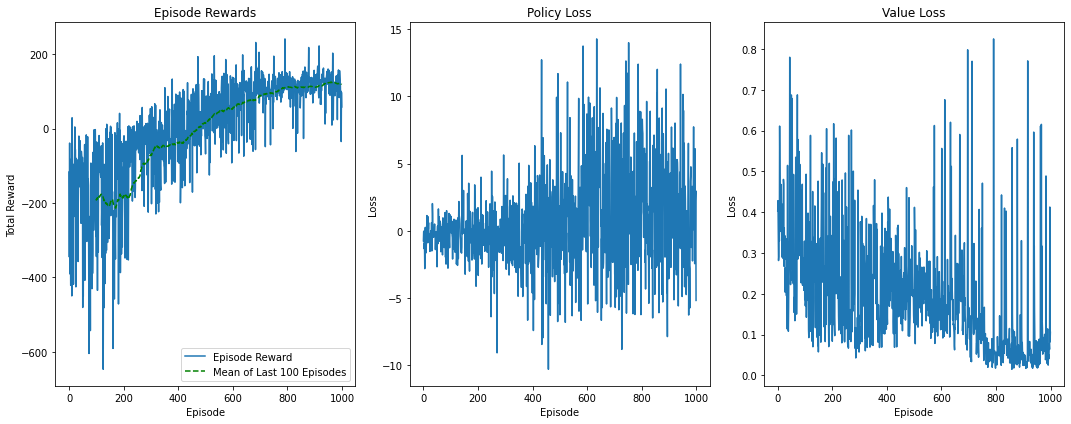

In [24]:
import matplotlib.pyplot as plt

# Episode Rewards Plot
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.plot(all_rewards, label='Episode Reward')
if len(mean_rewards) > 0:
    mean_line = [None] * 99 + mean_rewards  # Offset to align with last 100 episodes
    plt.plot(mean_line, 'g--', label='Mean of Last 100 Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.title('Episode Rewards')

# Policy Loss Plot
plt.subplot(1, 3, 2)
plt.plot(loss_history_policy)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Policy Loss')

# Value Loss Plot
plt.subplot(1, 3, 3)
plt.plot(loss_history_value)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Value Loss')

plt.tight_layout()
plt.show()
